In [1]:
from pathlib import Path
import os
import copy

import xarray as xr
import numpy as np
import pandas as pd

from eofs.xarray import Eof

from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

from deepS2S.utils.utils_plot import plot_examples
from deepS2S.preprocessing.regimes import get_general_probabilistic_regimes, get_dominant_regime

In [2]:
data_name = '20CRv3'
test = False #Set to true if you want to test the compatibility with the hindcast
cfd = Path(os.getcwd()).parent.absolute()
root = Path(cfd).parent.absolute()
data_dir = str(Path(root).parent.absolute()) + '/Data/'
par_cdf = cfd.parent.absolute()
results_directory = f'{data_dir}{data_name}/Preprocessing'
if not os.path.exists(results_directory):
        os.makedirs(results_directory)

In [20]:
# Load ERA5 Data.
start_yr = 1836
year_end = 1980
smoothing = 7
input_path = Path(f'{data_dir}{data_name}/datasets/z_500_1.40625deg_{start_yr}-{year_end}_northern_hemi_2d.nc')
z500_anomalies = xr.open_dataarray(input_path)

z500_anomalies = - z500_anomalies.sel(lon=slice(-90, 30), lat=slice(20,80)).squeeze()



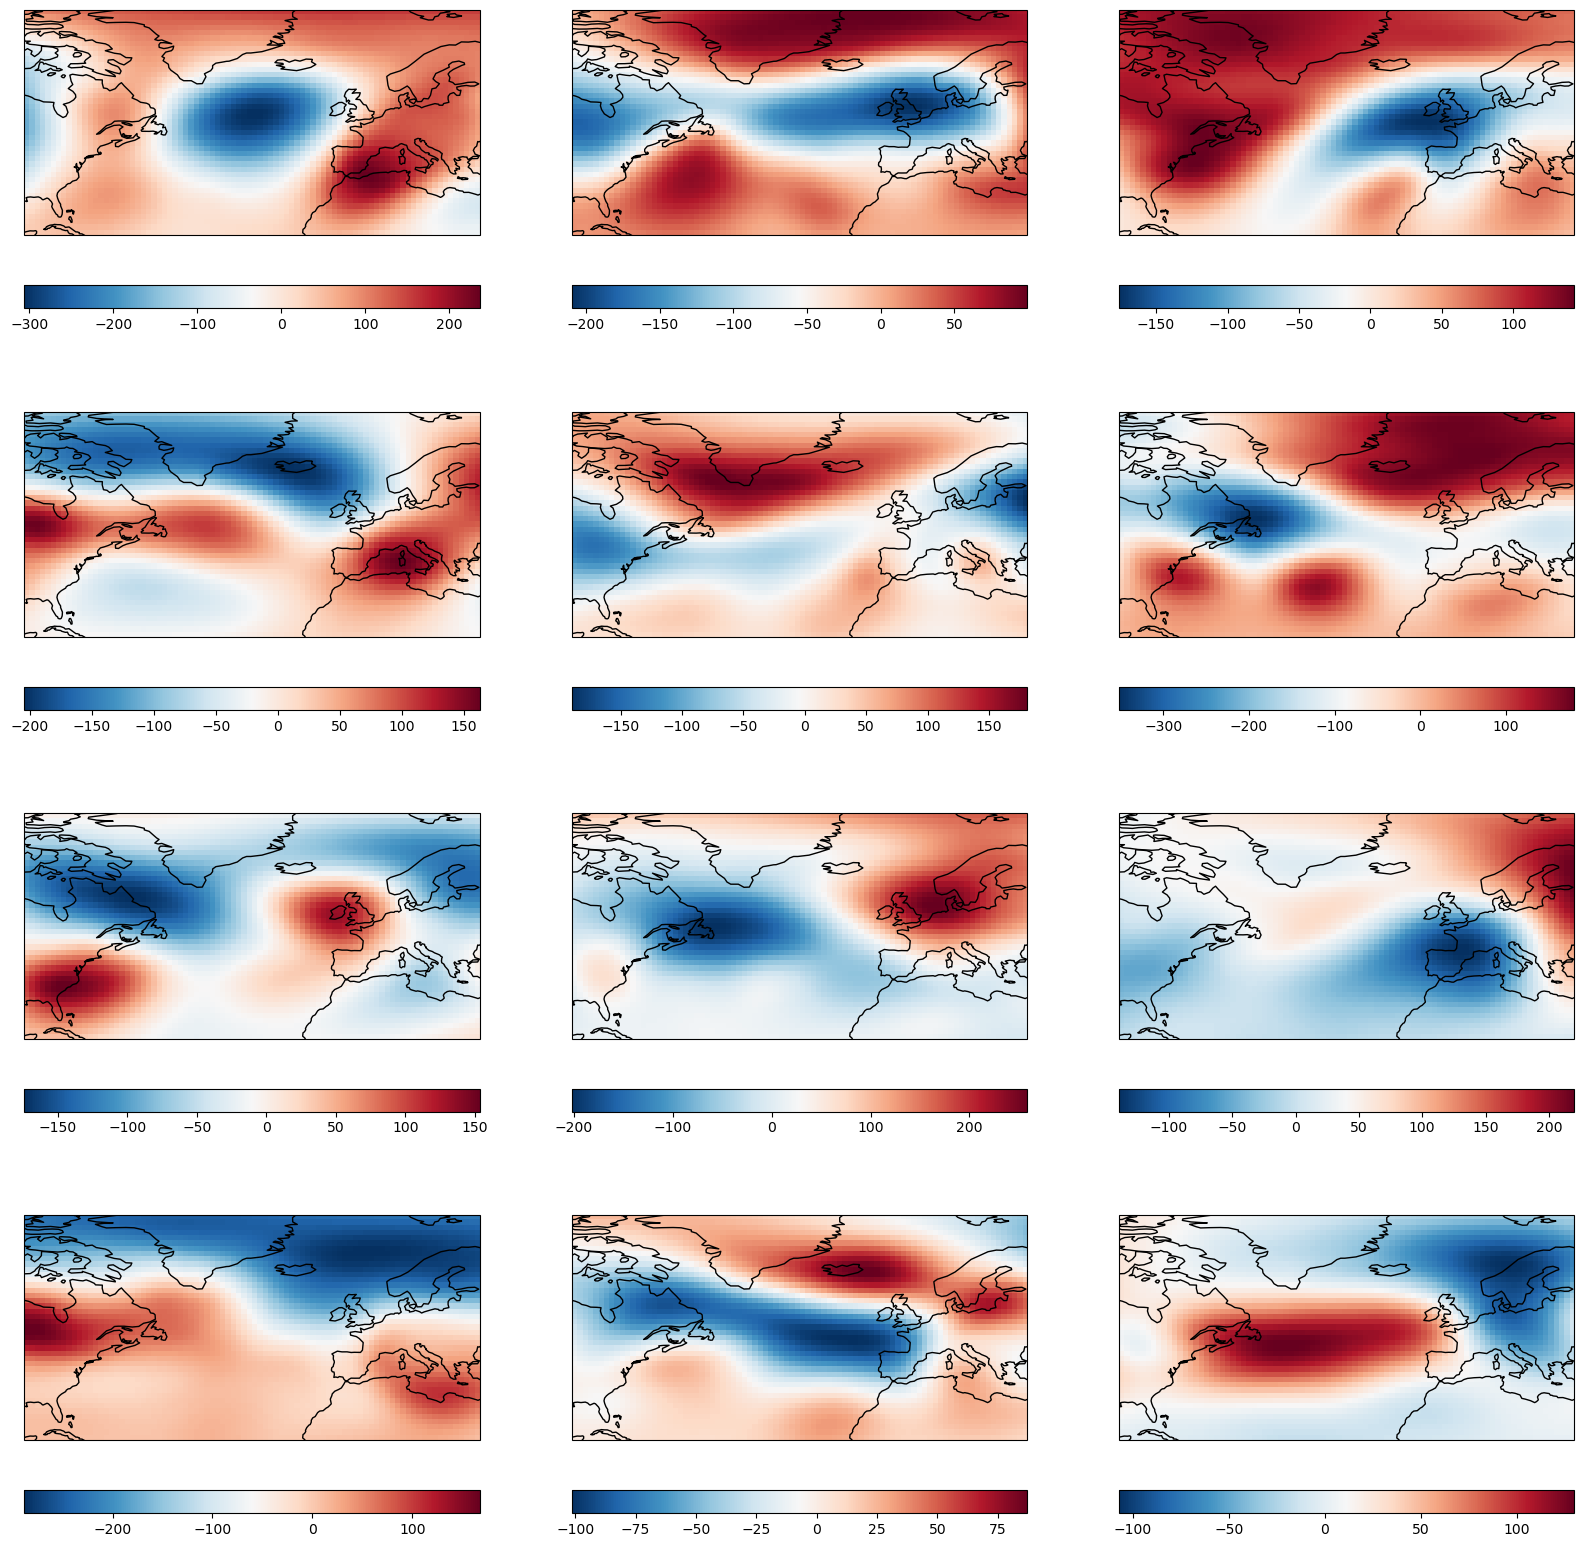

In [21]:
examples = np.random.choice(np.arange(len(z500_anomalies.time)), 12)
plot_examples(z500_anomalies, examples=examples)

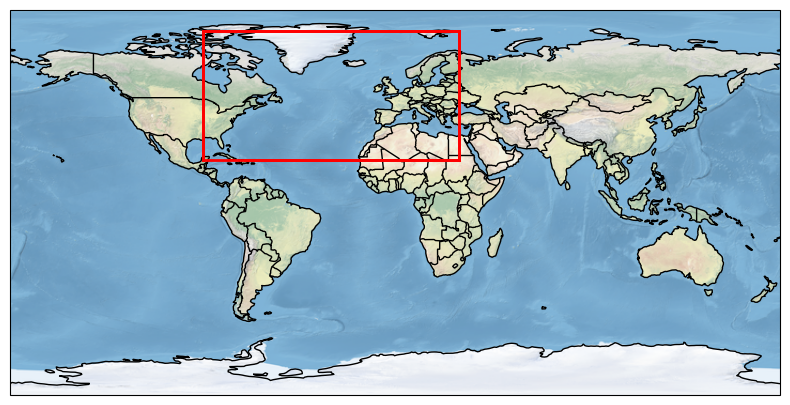

In [22]:
# Create a new figure
fig = plt.figure(figsize=(10, 5))

# Set up the map projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines and borders
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.BORDERS)

# Set the extent of the map to cover the whole world
ax.set_global()
ax.stock_img()

# Draw the red box
ax.plot([-90, 30], [20, 20], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([-90, 30], [80, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([-90, -90], [20, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([30, 30], [20, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)

# Draw the red box
ax.plot([-70, 30], [20, 20], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([-90, 30], [80, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([-90, -90], [20, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)
ax.plot([30, 30], [20, 80], transform=ccrs.PlateCarree(), color='red', linewidth=2)

fig.savefig(f'{results_directory}/NAE_map_section.pdf', bbox_inches='tight')

## Calculate regimes

In [23]:
# perform EOF analysis
num_m = 14

z500_anomalies = z500_anomalies.dropna('time')
weights = np.cos(np.deg2rad(z500_anomalies.lat))
z500_anomalies_weighted = z500_anomalies*weights

In [24]:
eof_solver = Eof(z500_anomalies_weighted.rename({'lon':'longitude', 'lat':'latitude'}), center=True)
pcs_z500 = eof_solver.pcs(npcs=num_m)
eofs_z500 = eof_solver.eofs()
kmeans = KMeans(n_clusters=4, n_init=50, random_state=0).fit(pcs_z500)

In [25]:
# assign each observation to the closest centroid
classes = list(kmeans.labels_)
for i in range(4):
    print(f'Number of observations in cluster {i}: {classes.count(i)/len(classes)*100}%')

Number of observations in cluster 0: 22.167687092040683%
Number of observations in cluster 1: 27.683044072256237%
Number of observations in cluster 2: 27.075848808379295%
Number of observations in cluster 3: 23.073420027323788%


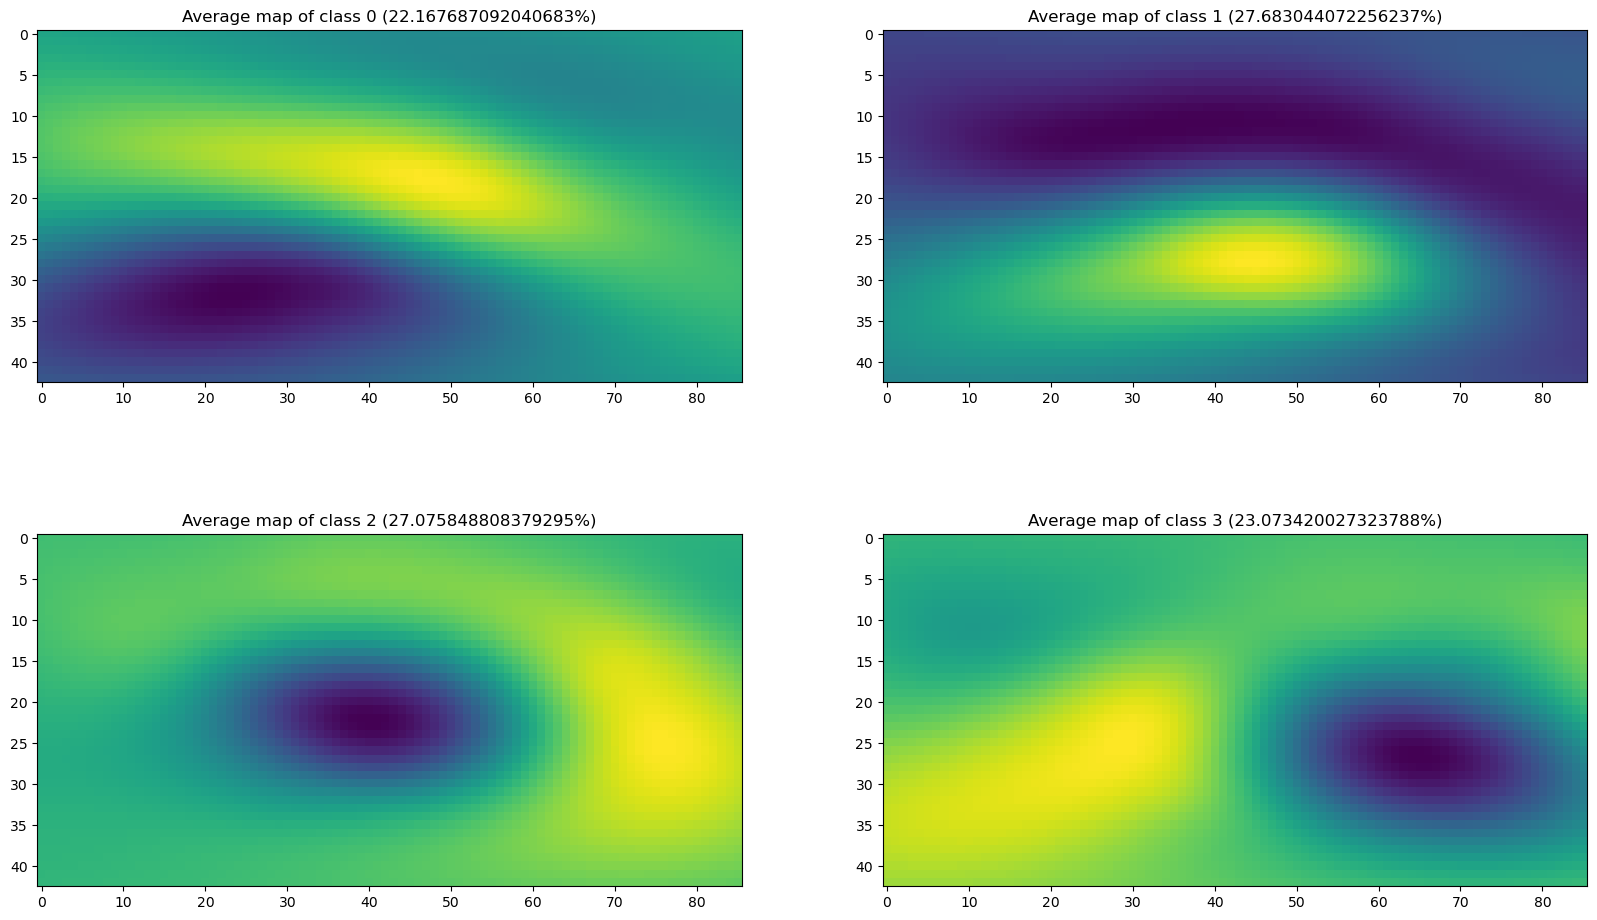

In [26]:
fig, axes = plt.subplots(2,2, figsize=(20,12))
mean_maps = {}
for c, ax in enumerate(axes.flatten()):
    samples_c = [i for i, x in enumerate(classes) if x == c]
    mean_maps[c] = z500_anomalies.isel(time=samples_c).mean('time')
    ax.imshow(mean_maps[c])
    ax.set_title(f'Average map of class {c} ({classes.count(c)/len(classes)*100}%)')

Text(0, 0.5, 'EOF2')

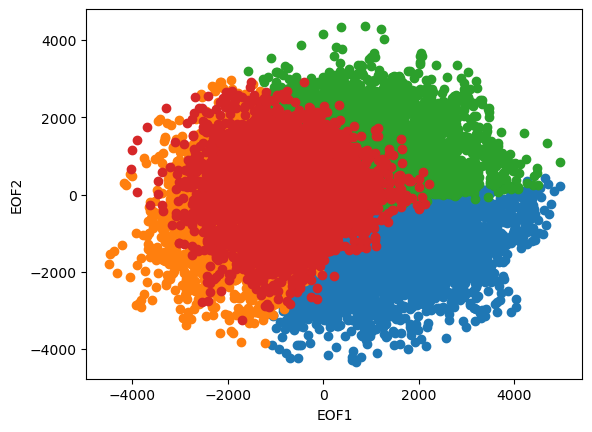

In [27]:
# Plot Cluster Point Clouds.
m = pcs_z500[:,:2].T

fig, ax = plt.subplots()
for c in range(4):
    samples_c = [i for i, x in enumerate(classes) if x == c]
    ax.scatter(*m[:,samples_c])
ax.set_xlabel('EOF1')
ax.set_ylabel('EOF2')

NAO -
Atlantic Ridge
NAO+
Scandinavian blocking


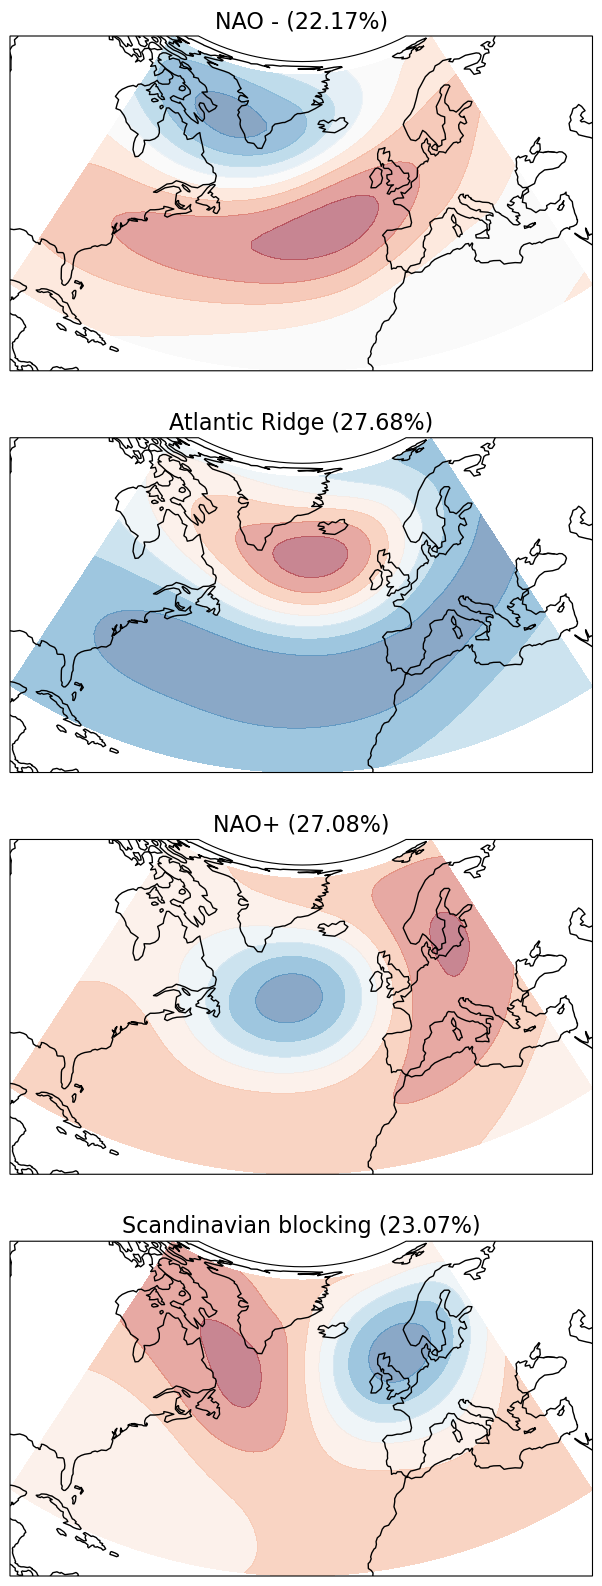

In [28]:
# Plot the leading EOF expressed as covariance in the European/Atlantic domain.

#Todo: Check!!!
cl_order = [0,1,2,3]
reg ={
        0: 'NAO -',
        1: 'Atlantic Ridge', 
        2: 'NAO+',
        3: 'Scandinavian blocking',
        }



proj = ccrs.AlbersEqualArea(central_longitude=-30, central_latitude=50)
fig, axes = plt.subplots(4,1,figsize=(8,20), subplot_kw=dict(projection=proj))
axes = axes
# for (c, data), ax in zip(mean_maps.items(), axes.flatten()):
for c, data in mean_maps.items():
    weights = np.cos(np.deg2rad(data.lat))
    
    data_weighted = data#/weights
    ax = axes[cl_order[c]]
    ax.coastlines()
    ax.contourf(data_weighted.lon.values, data_weighted.lat.values, data_weighted.squeeze().values, #vmin = -160, vmax = 160,
                cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), alpha=0.5, cbar=True)
    name_reg = reg[cl_order[c]]
    print(name_reg)
    ax.set_title(f'{name_reg} ({classes.count(cl_order[c])/len(classes)*100:.2f}%)', fontsize=16)
plt.show()

fig.savefig(f"{results_directory}/average_map_NAE_regimes_{start_yr}_{year_end}_{data_name}_{num_m}EOF.png", dpi=600, bbox_inches='tight')



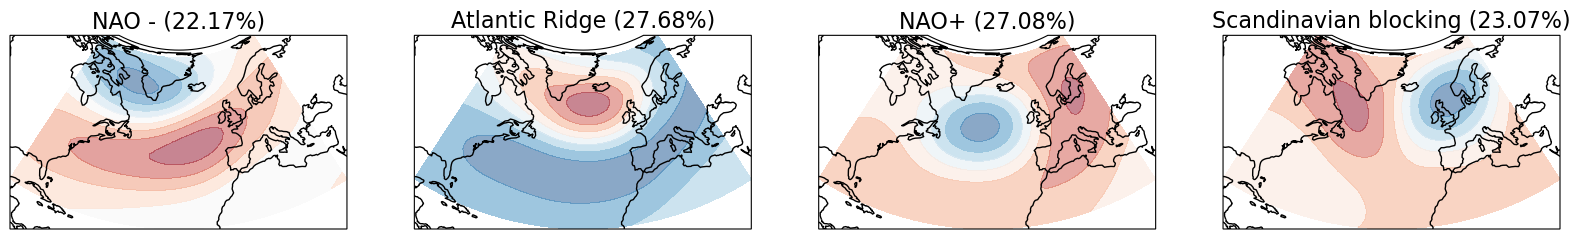

In [29]:
## horizontal figure


proj = ccrs.AlbersEqualArea(central_longitude=-30, central_latitude=50)
fig, axes = plt.subplots(1,4,figsize=(20,8), subplot_kw=dict(projection=proj))
axes = axes
for c, ax in enumerate(axes.flatten()):
    data = mean_maps[cl_order[c]]
    ax.contourf(data.lon.values, data.lat.values, data.squeeze().values,
                cmap=plt.cm.RdBu_r, transform=ccrs.PlateCarree(), alpha=0.5)
    name_reg = reg[cl_order[c]]
    ax.coastlines()
    ax.set_title(f'{name_reg} ({classes.count(cl_order[c])/len(classes)*100:.2f}%)', fontsize=16)
plt.show()

fig.savefig(f"{results_directory}/horizontal_map_NAE_regimes_{start_yr}_{year_end}_{data_name}_{num_m}EOF.png", dpi=600, bbox_inches='tight')



In [33]:
# Check !
regime_map = {
        0: 1,
        1: 2, 
        2: 3,
        3: 0,
        }

classes = np.array([regime_map[c] for c in classes])

In [34]:
# save the NAE regimes of the data points used to generate the clusters
nae_regimes_pat = input_path.parent / Path(f'{input_path.stem}_NAEregimes{input_path.suffix}')
nae_ds = xr.DataArray(
    data=np.array(classes),
    dims=['time'],
    coords=dict(
        time=z500_anomalies.time.values,
        season=('time', z500_anomalies.season.values)
    ),
    attrs=dict(
        description=("Time series of North atlantic weather regimes. "
                     "For each date in the time dimension one of four classes "
                     "was determined (SB(0), NAO-(1), AR(2), NAO+(3))."
                     "The basis for calculation were the Z500 anomalies over the North Atlantic "
                     "averaged over 7 consecutive days starting on the date specified as "
                     "time coordinate."
                    )
    )
)
nae_ds.to_netcdf(nae_regimes_pat)


### Compare to hindcast

In [38]:
nae_pd = nae_ds.to_dataframe(name = 'regime')
reg_names = []
for val in np.array(classes):
    reg_names.append(reg[val])

nae_pd = nae_pd.assign(regimes = reg_names)
nae_pd.to_csv(input_path.parent / Path(f'nae_regime_list_{num_m}EOFs.csv'))

In [39]:
if test:
    hind_regs = pd.read_csv('../Data/regime_labels_hindcast.csv').to_xarray()
    hind_regs = hind_regs.rename({'index': 'time'})
    hind_regs = hind_regs.assign_coords({'time': pd.to_datetime(hind_regs['Date'].values)})
    hind_regs = hind_regs.sel(time=nae_ds['time']).target_label

    regime_map = {
        0: 3,  
        1: 1,  
        2: 0,  
        3: 2   
    }


    hind_classes = np.array([regime_map[c] for c in hind_regs.values]) 

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(classes, hind_classes)

    # Normalize the confusion matrix by row (i.e., by the number of actual instances)
    conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2%', cmap='Blues')
    plt.xlabel('ERA5')
    plt.ylabel('Hindcast')
    plt.title('Confusion Matrix between ERA5 and Hindcast regimes (in %)')
    plt.show()

### Create climatologies for NAE

In [40]:
# Set climatology variables.
dataset = '20CRv3'
probabilistic = 0
regimes = ['SB(0)', 'NAO-(1)', "AR(2)", 'NAO+(3)']

days_dt = nae_ds.time.dt.dayofyear
day_dt = np.unique(days_dt.values)
day_dt.shape[0]

139

In [41]:
nae_sm = nae_ds

years = 30
last = nae_sm.isel(time=-1)
first = nae_sm.isel(time=0)
yrs = np.arange(first.time.dt.year.values, last.time.dt.year.values+1)

beg = '01-01'
end = '12-31'
for i in range(len(yrs)//years +1):
    if ((i+1)*years) > len(yrs):
        start_dt = np.datetime64(f'{yrs[i*years]}-{beg}')
        end_dt = last.time.values
    elif i == 0:
        start_dt = first.time.values
        end_dt = np.datetime64(f'{yrs[(i+1)*years-1]}-{end}') 
    else: 
        start_dt = np.datetime64(f'{yrs[i*years]}-{beg}')
        end_dt = np.datetime64(f'{yrs[(i+1)*years-1]}-{end}') 

    if probabilistic: 
        nae_clim = get_general_probabilistic_regimes(nae_sm.sel({'time':slice(start_dt,end_dt)}),regimes)
        types = f'prob_{smoothing}days_'
    else:
        nae_clim = nae_sm.sel({'time':slice(start_dt,end_dt)}).groupby('time.dayofyear').apply(get_dominant_regime)
        types = f'{smoothing}days_'
       
    if ((i+1)*years) > len(yrs):
        nae_clim.to_netcdf(f'{data_dir}{dataset}/climatology/NAE_{num_m}eofs_{types}climatology_{yrs[i*years]}_{last.time.dt.year.values}.nc', engine ="netcdf4")
    else:
        nae_clim.to_netcdf(f'{data_dir}{dataset}/climatology/NAE_{num_m}eofs_{types}climatology_{yrs[i*years]}_{yrs[(i+1)*years-1]}.nc', engine ="netcdf4")